[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1/15
563/563 [==============================] - 89s 144ms/step - loss: 0.9415 - accuracy: 0.7943 - val_loss: 0.3789 - val_accuracy: 0.8555
Epoch 2/15
563/563 [==============================] - 42s 74ms/step - loss: 0.3645 - accuracy: 0.8816 - val_loss: 0.3495 - val_accuracy: 0.8683
Epoch 3/15
563/563 [==============================] - 29s 52ms/step - loss: 0.2864 - accuracy: 0.9106 - val_loss: 0.3470 - val_accuracy: 0.8683
Epoch 4/15
563/563 [==============================] - 25s 44ms/step - loss: 0.2488 - accuracy: 0.9243 - val_loss: 0.3841 - val_accuracy: 0.8562
Epoch 5/15
313/313 [==============================] - 4s 14ms/step - loss: 0.3309 - accuracy: 0.8752
Test accuracy: 0.8752
313/313 [==============================] - 5s 12ms/step
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      4961
    positive       0.90      0.84      0.87      5039

    accuracy                           0.88     10000
   macro avg       0.88   

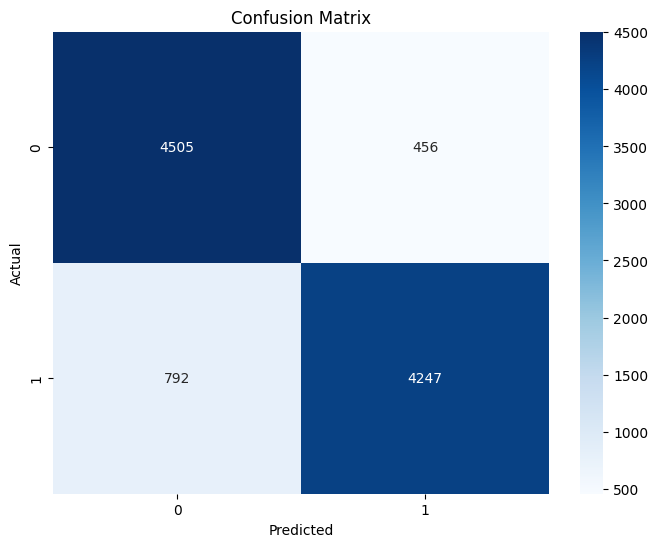

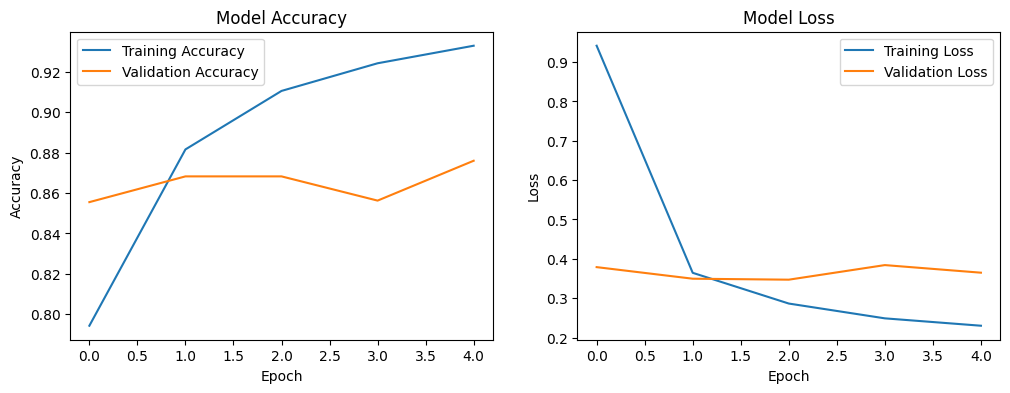

1/1 [==============================] - 0s 26ms/step
Review: This movie was absolutely fantastic! I loved every minute of it.
Predicted sentiment: Positive
Confidence: 0.9370
Top 20 most important words:
worst: 2.9205
mstk: 2.5286
waste: 2.4395
refreshing: 2.3417
forgettable: 2.0169
awful: 1.9762
unwatchable: 1.9466
icet: 1.9401
miscast: 1.8716
embarrassment: 1.8641
assorted: 1.8442
boring: 1.7938
horrible: 1.7755
boredom: 1.7605
bittersweet: 1.7595
disappointing: 1.7502
baldwin: 1.7446
quibble: 1.7106
fantastic: 1.7077
saving: 1.6998


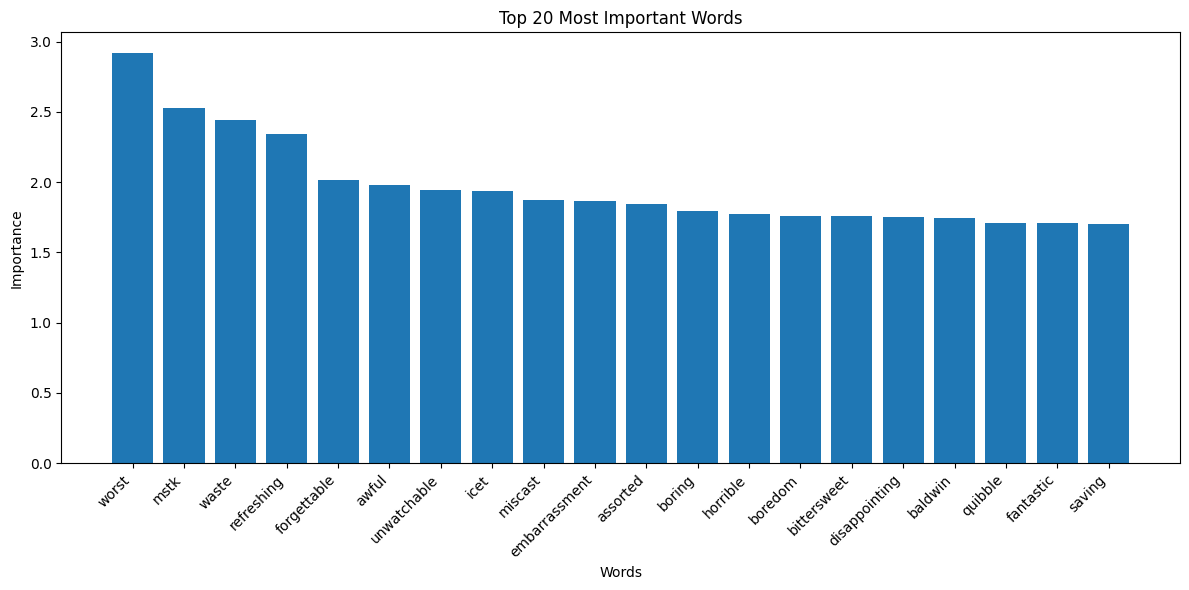

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# download the NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# load our dataset
data = pd.read_csv('test.csv')

# preprocessing data
def preprocess_text(text):
    # remove html tags
    text = re.sub(r'<.*?>', '', text)
    # remove special chars
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = text.lower()
    # tokenize
    tokens = nltk.word_tokenize(text)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# apply preprocessing to data
data['cleaned_review'] = data['review'].apply(preprocess_text)

# encode sentiment labels
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

# train-test split
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_review'], data['sentiment_encoded'], test_size=0.2, random_state=42)

# tokenize and pad
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.regularizers import l2

# build LSTM with adjustments to combat overfitting
embedding_dim = 100

model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# adjust the early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=15,  # max epochs icnreased
    batch_size=64,  # batch size increased
    validation_split=0.1,
    callbacks=[early_stopping]
)

# model evaluation
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {accuracy:.4f}")

# predictions
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# classificaiton report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# training history plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# function to predict sentiment review
def predict_sentiment(review):
    cleaned_review = preprocess_text(review)
    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded_sequence)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return sentiment, prediction

# example of usage
new_review = "This movie was absolutely fantastic! I loved every minute of it."
sentiment, confidence = predict_sentiment(new_review)
print(f"Review: {new_review}")
print(f"Predicted sentiment: {sentiment}")
print(f"Confidence: {confidence:.4f}")

# analysis of most important words
word_importance = {}
for word, idx in tokenizer.word_index.items():
    if idx < max_words:
        embedding_vector = model.layers[0].get_weights()[0][idx]
        importance = np.linalg.norm(embedding_vector)
        word_importance[word] = importance

top_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)[:20]
print("Top 20 most important words:")
for word, importance in top_words:
    print(f"{word}: {importance:.4f}")

# visualize word importance
plt.figure(figsize=(12, 6))
words, importances = zip(*top_words)
plt.bar(words, importances)
plt.title('Top 20 Most Important Words')
plt.xlabel('Words')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
data.head()
#shape of dataframe

,review,sentiment,cleaned_review,sentiment_encoded
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,1
